This is the notebook to show the implementation of score-based generative model (1st part of the tutorial). In this case, we will sample the training data from the swiss roll distribution.
From the training data, we will try to learn how to draw new samples from the swiss roll distribution with Score-based Generative Model (SGM)

In [1]:
import torch
from sklearn.datasets import make_swiss_roll

# generate the swiss roll dataset
xnp, _ = make_swiss_roll(1000, noise=1.0)
xtns = torch.as_tensor(xnp[:, [0, 2]] / 10.0, dtype=torch.float32)
dset = torch.utils.data.TensorDataset(xtns)

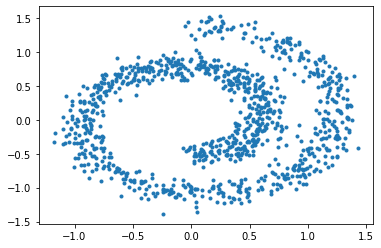

In [2]:
# show the samples
import matplotlib.pyplot as plt
plt.plot(xtns[:, 0], xtns[:, 1], 'C0.')

Now let's define the neural network that will learn the score function.
This is just a simple multi-layer perceptron with LogSigmoid activation function.
I used logsigmoid because of personal preference, you can also use ReLU.

In [3]:
# score_network takes input of 2 dimension and returns the output of the same size
score_network = torch.nn.Sequential(
    torch.nn.Linear(2, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 64),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(64, 2),
)

Now let's implement the first and second terms of the loss function below,
$$\begin{equation}
\mathcal{L}(\theta) = \mathbb{E}_{\mathbf{x}\sim p(\mathbf{x})}\left[\frac{1}{2} \left\lVert\mathbf{s}(\mathbf{x};\theta)\right\rVert^2 + \mathrm{tr}\left(\nabla_\mathbf{x} \mathbf{s}(\mathbf{x}; \theta)\right) + g(\mathbf{x})\right].
\end{equation}$$
To get the Jacobian, we will use the function from ``functorch``.

In [4]:
from functorch import jacrev, vmap

def calc_loss(score_network: torch.nn.Module, x: torch.Tensor) -> torch.Tensor:
    # x: (batch_size, 2) is the training data
    score = score_network(x)  # score: (batch_size, 2)
    
    # first term: half of the squared norm
    term1 = torch.linalg.norm(score, dim=-1) ** 2 * 0.5
    
    # second term: trace of the Jacobian
    jac = vmap(jacrev(score_network))(x)  # (batch_size, 2, 2)
    term2 = torch.einsum("bii->b", jac)  # compute the trace
    return (term1 + term2).mean()


Everything is ready, now we can start the training.

In [5]:
# start the training loop
import time
opt = torch.optim.Adam(score_network.parameters(), lr=3e-4)
dloader = torch.utils.data.DataLoader(dset, batch_size=32, shuffle=True)
t0 = time.time()
for i_epoch in range(5000):
    total_loss = 0
    for data, in dloader:
        opt.zero_grad()

        # training step
        loss = calc_loss(score_network, data)
        loss.backward()
        opt.step()
        
        # running stats
        total_loss = total_loss + loss.detach().item() * data.shape[0]
    
    # print the training stats
    if i_epoch % 500 == 0:
        print(f"{i_epoch} ({time.time() - t0}s): {total_loss / len(dset)}")


0 (0.17638111114501953s): -0.05398901349306107
500 (70.5479645729065s): -22.11136506652832
1000 (132.07090663909912s): -46.269107513427734
1500 (200.77129483222961s): -52.43773007202149
2000 (261.32592582702637s): -57.97596343994141
2500 (323.2231526374817s): -60.72849333190918
3000 (383.2428951263428s): -64.88924407958984
3500 (457.6815972328186s): -67.66869757080079
4000 (520.3891460895538s): -71.52150952148438
4500 (578.3121054172516s): -74.47203161621094


Once the neural network is trained, we can generate the samples using Langevin MCMC.

$$\begin{equation}
    \mathbf{x}_{i + 1} = \mathbf{x}_i + \varepsilon \nabla_\mathbf{x}\mathrm{log}\ p(\mathbf{x}) + \sqrt{2\varepsilon} \mathbf{z}_i
\end{equation}$$

where $\mathbf{z}_i\sim\mathcal{N}(\mathbf{0}, \mathbf{I})$ is a random number sampled from the normal distribution.

In [6]:
def generate_samples(score_net: torch.nn.Module, nsamples: int, eps: float = 0.001, nsteps: int = 1000) -> torch.Tensor:
    # generate samples using Langevin MCMC
    # x0: (sample_size, nch)
    x0 = torch.rand((nsamples, 2)) * 2 - 1
    for i in range(nsteps):
        z = torch.randn_like(x0)
        x0 = x0 + eps * score_net(x0) + (2 * eps) ** 0.5 * z
    return x0

In [7]:
samples = generate_samples(score_network, 1000).detach()

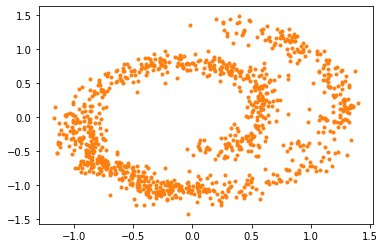

In [8]:
plt.plot(samples[:, 0], samples[:, 1], 'C1.')